In [9]:
import json
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import matplotlib as plt

In [75]:
test_annotation_file_path = "../../data/processed/detection/test/_annotations.coco.json"
root_dir = "../../data/processed/detection"

In [76]:
with open(test_annotation_file_path, 'r') as f:
    data = json.load(f)

In [ ]:
import cv2
import numpy as np
class DetectionDataset(Dataset):
    def __init__(self, root_dir, dataset_type='test'):
        self.root_dir = os.path.join(root_dir, dataset_type)
        annotation_path = os.path.join(self.root_dir, "_annotations.coco.json")
        with open(annotation_path, 'r') as f:
            data = json.load(f)
        self.images = data['images']
        self.labels = [[] for _ in range(len(self.images))]
        for each in data['annotations']:
            image_id = each['image_id']
            self.labels[image_id].append(each['bbox'])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_file_path = os.path.join(self.root_dir, self.images[index]['file_name'])
        bboxes = np.stack(self.labels[index])

        img = cv2.imread(image_file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if bboxes is None:
            return np.array([])
        bboxes[:, [2, 3]] = bboxes[:, [2, 3]]  + bboxes[:, [0, 1]]
        return img, bboxes


        


In [107]:
test_data = DetectionDataset(root_dir=root_dir, dataset_type='train')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

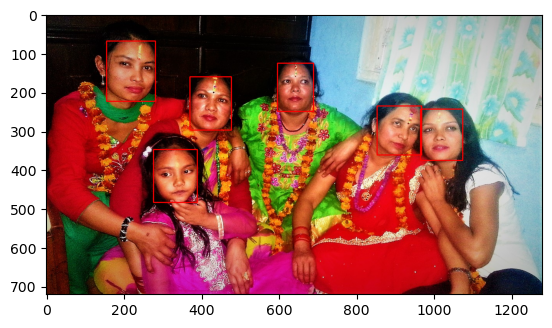

In [ ]:
import matplotlib.pyplot as plt
from face_pipeline import FacePipeline

model = FacePipeline()


def bound_faces(image, boxes):
    img = image.copy()
    plt.cla()
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    plt.imshow(img)
    plt.show()

img_path = r"C:\Users\rohan\Desktop\datasets\13.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


model = FacePipeline()
boxes_pred = model.get_boxes(img)
emmbeds = model.get_embeddings(img)
for each in emmbeds:
    print('mag', np.linalg.norm(each))
print(boxes_pred.shape)
bound_faces(img, boxes_pred.astype(int))

In [110]:
def calculate_iou(box1, box2):

    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
 
    if inter_xmax < inter_xmin or inter_ymax < inter_ymin:
        return 0.0
    

    inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)
    

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    

    union_area = box1_area + box2_area - inter_area
    

    iou = inter_area / union_area if union_area > 0 else 0.0
    
    return iou


def calculate_iou_batch(boxes1, boxes2):
    
    iou_matrix = np.zeros((len(boxes1), len(boxes2)))
    
    for i, box1 in enumerate(boxes1):
        for j, box2 in enumerate(boxes2):
            iou_matrix[i, j] = calculate_iou(box1, box2)
    
    return iou_matrix


def count_tp_fp_fn(predicted_boxes, ground_truth_boxes, iou_threshold=0.5):
    
    
    if (len(predicted_boxes) == 0 and len(ground_truth_boxes) == 0):
        return 0, 0, 0
    
    if len(predicted_boxes) == 0:
        
        return 0, 0, len(ground_truth_boxes)
    
    if len(ground_truth_boxes) == 0:
        
        return 0, len(predicted_boxes), 0
    
    
    iou_matrix = calculate_iou_batch(predicted_boxes, ground_truth_boxes)
    
    tp = 0
    fp = 0
    fn = 0
    matches = []
    matched_gt_indices = set()
    
    
    for pred_idx in range(len(predicted_boxes)):
        
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx in range(len(ground_truth_boxes)):
            if gt_idx in matched_gt_indices:
                continue
            
            if iou_matrix[pred_idx, gt_idx] > best_iou:
                best_iou = iou_matrix[pred_idx, gt_idx]
                best_gt_idx = gt_idx
        
      
        if best_iou >= iou_threshold:
            tp += 1
            matched_gt_indices.add(best_gt_idx)
            matches.append((pred_idx, best_gt_idx, best_iou))
        else:
            fp += 1
    

    fn = len(ground_truth_boxes) - len(matched_gt_indices)
    
    return tp, fp, fn


def calculate_metrics(tp, fp, fn):
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [111]:
model = FacePipeline()
TP, FP, FN = 0, 0, 0
i = 0
for img, boxes in test_data:
    i += 1
    box_pred = model.get_boxes(img)
    tp, fp, fn = count_tp_fp_fn(box_pred, boxes)
    TP, FP, FN = TP + tp, FP + fp, FN + fn
    print(i)

print(calculate_metrics(TP, FP, FN))


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\rohan/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [ ]:
with open('arcface_detection.json', 'w') as f:
    json.dump(calculate_metrics(TP, FP, FN), f, indent=2)